# Approximate inference in a PyMC3 model using Mici

This notebook illustrates how Mici can be used to sample from the posterior distribution of a model defined using [PyMC3](https://github.com/pymc-devs/pymc3). PyMC3 has its own implementations of inference algorithms, including the Hamiltonian Monte Carlo method used below. Mici is used here to demonstrate how to set up the various objects required to sample from a target distribution using Mici, and their relation to the corresponding concepts and objects in PyMC3.

In [1]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import mici
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

## Model definition

As an example model we use a hiearchical linear regression model for predicting radon levels in houses, reusing the model code from [this tutorial by Danne Elbers and Thomas Wiecki in the PyMC3 documentation](https://docs.pymc.io/notebooks/GLM-hierarchical.html). As our emphasis here is on the mechanics of performing inference with Mici rather than the details of this specific model or PyMC3's probabilistic programming syntax, we simply reproduce the model code verbatim &mdash; the tutorial can be referred to for more details on these topics. Most of the following code will work for any other PyMC3 model which includes only continuous latent (unobserved) variables and a convenience function is provided at the end of notebook to allow Mici to be easily used with other PyMC3 models. 

In [2]:
data = pd.read_csv(pm.get_data('radon.csv'))
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values
n_counties = len(data.county.unique())

with pm.Model() as model:
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_counties)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)
    eps = pm.HalfCauchy('eps', 5.)
    radon_est = a[county_idx] + b[county_idx]*data.floor.values
    radon_like = pm.Normal('radon_like', mu=radon_est, sigma=eps, observed=data.log_radon)

## Log density function and gradient

The key model-specific objects required to perform inference using Mici are:
 
  1. a function $\ell: \mathbb{R}^{D} \to \mathbb{R}$ which computes the *negative* logarithm of a density function for the target distribution of interest on a $D$-dimensional Euclidean space,
  2. a function which computes the gradient $\nabla \ell: \mathbb{R}^{D} \to \mathbb{R}^D$ of the negative log density and returns either just the gradient, or a tuple of the gradient *and* the value of the negative log density.

Mici expects that the target distribution has support on all of $\mathbb{R}^{D}$ and that the latent vector is represented as a flat NumPy array of shape $(D,)$ where $D$ = `model.ndim`. In PyMC3 terms this means we need a negative log density function for the model's posterior distribution parameterised in terms of the unconstrained transforms of any bounded random variables and which accepts a 1D NumPy array corresponding to flattened values for all the latent (unobserved / free) random variables in the model concatenated in to a single array. Fortunately PyMC3 models provide a method `model.logp_dlogp_function` which constructs a callable object which does most of the hard work for us.

In [3]:
val_and_grad_log_dens = model.logp_dlogp_function()

The output `val_and_grad_log_dens` of the `model.logp_dlogp_function` call is an instance of `pymc3.model.ValueGradFunction`. If this object is called with a NumPy array of the correct dimensions (i.e. a 1D array of shape `(model.ndim,)`) then a 2-tuple is returned with first value a NumPy scalar corresponding to the value of the logarithm of the density of the model's posterior distribution at the point in the latent space specified by the passed array, and the second value a 1D NumPy array corresponding to the gradient of the log density at this point. Before we can call the object we need to do a little book-keeping first by specifying that all the latent random variables in the model are inputs to the function and so there are no 'extra' variables that we need to provide fixed values for.

In [4]:
val_and_grad_log_dens.set_extra_values({})

We can now wrap this `val_and_grad_log_dens` object in functions which have the interface required by Mici. The key model specific object in Mici is an instance of a Hamiltonian system class defined in the `mici.systems` module. For our purposes we require a `mici.systems.EuclideanMetricSystem` which corresponds to a Hamiltonian system on a Euclidean space with fixed metric matrix representation (mass matrix). The constructor for this class takes two function arguments `neg_log_dens` and `grad_neg_log_dens`, corresponding to unsuprisingly the negative log density of the target distribution and gradient of this negative log density. Optionally a `metric` argument can also be passed to specify a particular metric matrix representation; by default this is set to an identity matrix however we will use an adaptive algorithm to set this metric later.

As in PyMC3, Mici leverages the fact that typically the value of a function is evaluated as an intermediate quantity when computing the gradient of that function using reverse-mode algorithmic differentiation by caching the value when the gradient is computed to prevent the need for subsequent recomputation. We therefore specify the `grad_neg_log_dens` function to return a 2-tuple, with first value an array corresponding to gradient of the *negative* of the log density function (i.e. the negation of the second value returned by `val_and_grad_log_dens`) and second value a scalar corresponding to the negative log density itself (i.e. the negation of the first value returned by `val_and_grad_log_dens`).

In [5]:
def grad_neg_log_dens(pos):
    val, grad = val_and_grad_log_dens(pos)
    return -grad, -val

As the system class constructor also requires a function `neg_log_dens` returning just a scalar corresponding to the negative log density, we also define a function wrapping `val_and_grad_log_dens` which returns only the negation of its first return value. While this may seem wasteful as we are needlessly evaluating the gradient, in reality there is only a small constant overhead to evaluate both the gradient and value, and more importantly because of the previously mentioned caching Mici will only evaluate this function a small number of times for each chain, with cached values from gradient evaluations being available for the vast majority of calls.

In [6]:
def neg_log_dens(pos):
    val, _ = val_and_grad_log_dens(pos)
    return -val

## Setting up *Mici* objects

We can now construct a Mici system class instance using the just defined `neg_log_dens` and `grad_neg_log_dens` functions. The resulting `system` object defines a number of methods which encapsulate various system specific functions such as the Hamiltonian and its derivatives. 

In [7]:
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_dens, 
    grad_neg_log_dens=grad_neg_log_dens
)

print(', '.join(attr for attr in dir(system) if attr[0] != '_'))

dh1_dpos, dh2_dmom, dh2_flow_dmom, dh_dmom, dh_dpos, grad_neg_log_dens, h, h1, h1_flow, h2, h2_flow, metric, neg_log_dens, sample_momentum


Most of the system methods take a `mici.states.ChainState` instance as their first (or only) argument. A `ChainState` object in Mici encapsulates the current state of a Hamiltonian system which is minimally specified by a position (`pos`, a 1D array), momentum (`mom`, a 1D array) and integration 'direction' (`dir`, either +1 or -1) corresponding to whether the Hamiltonian dynamics are currently being simulated forward (`dir=1`) or backwards (`dir=-1`) in time. In addition to these variables, a `ChainState` instance may also contain cached values of quantities deterministically derived from these variables by a Hamiltonian system object &mdash; for example the current Hamiltonian value or its derivatives. By caching these values Mici ensures potentially expensive to evaluate functions are only evaluate once for each value of the state variables they depend on.

In addition to the system and state objects, another key class of Mici objects are the integrator classes in the `mici.integrators` module. For the `EuclideanMetricSystem` class we are using here, the `LeapfrogIntegrator` is an appropriate choice of integrator, for this system corresponding to the standard Störmer-Verlet or leapfrog integrator for separable Hamiltonian systems. The `LeapfrogIntegrator` initialiser takes as arguments a Hamiltonian system instance and optionally a floating point `step_size` parameter corresponding to the time-step used in the numerical discretisation of the Hamiltonian dynamics. As we will use an adaptive algorithm to set the step size we do not pass a `step_size` value in here.

In [8]:
integrator = mici.integrators.LeapfrogIntegrator(system)

Another key group of Mici objects are the sampler classes in the `mici.samplers` module. A sampler object uses a Hamiltonian system and associated integrator to simulate Markov chains which leave the target distribution represented by the system invariant. The simplest sampler is the `StaticMetropolisHMC` class which corresponds to the 'basic' Hybrid Monte Carlo algorithm proposed by [Duane, Kennedy, Pendleton and Roweth (1987)](https://doi.org/10.1016%2F0370-2693%2887%2991197-X): each new state is proposed by integrating the dynamic forward a fixed number of steps and accepting or rejecting the move from the initial to final state on the trajectory in a Metropolis accept step. These 'integration' chain transitions in which the position and momentum components are jointly updated are alternated with transitions in which only the momentum is updated, with the default being to independently resample the momentum from its conditional distribution given the current position.

In addition to the `StaticMetropolisHMC` class, Mici also provides other sampler classes such as the `RandomMetropolisHMC` class which instead integrates the state a randomly sampled rather than fixed number of steps in each integration transition, and the `DynamicSliceHMC` class which uses a heuristic 'no-U-turn' criterion to dynamically determine how many integration steps to take and uses a slice sampling scheme to sample the new state from the whole recursively generated trajectory [(Hoffman and Gelman, 2014)](http://jmlr.org//papers/v15/hoffman14a.html). Here we use instead the `DynamicMultinomialHMC` class which also dynamically sets the number of integration steps per chain iteration but uses a more efficient multinomial scheme to sample the new state from the trajectory [(Betancourt, 2017)](https://arxiv.org/abs/1701.02434). This corresponds to the default inference algorithm used in both PyMC3 and Stan.

The `DynamicMultinomialHMC` constructor has three required arguments: a Hamiltonian system and integrator (as both defined above) and [a NumPy random number generator](https://numpy.org/doc/stable/reference/random/generator.html). The constructor also takes optional keyword arguments:

  * `max_tree_depth`: The maximum depth to expand the binary trajectory tree to in each chain iteration. The maximum number of integrator steps per chain iteration is equal to `2**max_tree_depth - 1`. By default this is set to 10 corresponding to allowing trajectories of up to 1023 steps. 
  * `max_delta_h`: Maximum change to tolerate in the Hamiltonian function over a trajectory in before terminating and signalling a [divergence](https://mc-stan.org/docs/2_25/reference-manual/divergent-transitions.html).
  * `termination_criterion`: Function computing criterion to use to determine when to terminate trajectory tree expansion. Defaults to `mici.samplers.riemannian_no_u_turn_criterion` which corresponds to the generalised no-U-turn criterion proposed by [Betancourt (2013)](https://arxiv.org/abs/1304.1920).
  * `do_extra_subtree_checks`: Whether to perform additional termination criterion checks on overlapping subtrees of the trajectory binary tree to [increase robustness of the no-U-turn criterion](https://discourse.mc-stan.org/t/nuts-misses-u-turns-runs-in-circles-until-max-treedepth). Defaults to `True`.
  * `momentum_transition`: Markov transition kernel which leaves the conditional distribution on the momentum invariant, updating only the momentum component of the chain state. By default `mici.transition.IndependentMomentumTransition` is used, which independently samples the momentum from its conditional distribution.
 

In [9]:
seed = 202012
rng = np.random.default_rng(seed=seed)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)

As mentioned earlier we will adaptively set the integrator step size and metric matrix representation during warm-up chain iterations. In Mici adaptation of algorithmic parameters of the transitions is performed using the adapter classes defined in the `mici.adapters` module. Here we use two adapters - a step-size adapter which uses the dual-averaging algorithm described in [Hoffman and Gelman (2014)](http://jmlr.org//papers/v15/hoffman14a.html) to tune the step size to achieve a target acceptance statistic, and a metric adapter which sets a diagonal metric matrix representation based on online estimates of the marginal posterior variances of the latent variables. This combination corresponds to the adaptation performed with `init='adapt_diag'` or `init='jitter+adapt_diag'` in PyMC3.  For the step-size adapter we set a target acceptance statistic of 0.9 to replicate [the settings used in the tutorial the model code was taken from](https://docs.pymc.io/notebooks/GLM-hierarchical.html#Hierarchical-Model).

In [10]:
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(adapt_stat_target=0.9),
    mici.adapters.OnlineVarianceMetricAdapter()
]

## Specifying traced variables

While internally Mici represents the position component of the chain state as a 1D array, the variables traced over the chains during sampling can be customised to store the chain data in a more useful format. Here we can use the `array_to_dict` method of the `val_and_grad_log_dens` object earlier created from the PyMC3 model to convert the 1D array to a dictionary of arrays corresponding to the latent random variables in the original model. As some of these variables corresponds to unconstrained transforms of the original bounded random variables, we here also compute the untransformed variables and add them to the returned dictionary. We also additionally record the value of the Hamiltonian under the key `'energy'`, as this can be useful for some diagnostics. In general the trace functions can be specified by a list of one or more functions which accept a `mici.states.ChainState` object as the single argument and return a dictionary of NumPy arrays (or array-like objects) keyed by strings corresponding to the variable names.

In [11]:
def trace_func(state):
    var_dict = val_and_grad_log_dens.array_to_dict(state.pos)
    for rv in model.unobserved_RVs:
        if rv.name in var_dict:
            continue
        else:
            var_dict[rv.name] = rv.transformation.backward_val(var_dict[rv.transformed.name])
    var_dict['energy'] = system.h(state)
    return var_dict

## Generating chain initial states

A final task before we sample the chains is to choose the states the chains are initialised at. Here we use the `sample_prior_predictive` function from PyMC3 to generate samples from the prior distribution on the model latent variables and use these prior samples to construct the 1D arrays corresponding to the position components of the initial chain states using the `dict_to_array` method of `val_and_grad_log_dens` object created earlier. We sample four initial states here so that we can run four chain in parallel. We can either specify the initial states as a list of 1D arrays corresponding to just the position components of the chain states or as a list of `ChainState` instances which also specify the initial momentum components of the chain states. If only the positions are specified the initial momentums are independently sampled from their conditional distribution given the positions.

In [12]:
n_chain = 4
prior_samples = pm.sample_prior_predictive(n_chain, model, random_seed=seed)
init_states = [
    val_and_grad_log_dens.dict_to_array({k: v[c] for k, v in prior_samples.items()})
    for c in range(n_chain)
]

## Sampling chains with adaptive warm up

We are now finally in a position to begin sampling! The key method of interest of a sampler object is `sample_chains_with_adaptive_warm_up` which samples one or Markov chains from specified initial states (specified by a list of NumPy arrays or `ChainState` objects passed as the `init_states` argument), first performing a number of adaptive warm-up iterations (specified by the integer `n_warm_up_iter` argument) where the adapters tune the transition parameters before running a further set of 'main' chain iterations (specified by the integer `n_main_chain_iter` argument) where the returned chain traces are generated. 

As well as the three required arguments `n_warm_up_iter`, `n_main_iter` and `init_states` there are also a number of optional keyword arguments to the `sample_chains_with_adaptive_warm_up` method. The `adapters` argument allows passing in a custom list of adapter objects to use in the warm-up phase - here we pass in the list of adapters created earlier (by default only a step-size adapter is used). As described previously the `trace_funcs` argument allows specifying functions controlling what chain variables are traced during sampling - here we use the `trace_func` function we defined above (by default `trace_funcs` consists of a single function returning the position component of the state under the key `pos` and the Hamiltonian under the key `h`). Multiple chains can be sampled in parallel in separate processes by setting the `n_process` argument to an integer more than one (here we use one process per chain). During sampling by default Mici displays a progress bar for each chain showing how many chain iterations have been completed so far, the expected time to completion and running averages of chain statistics such as the acceptance probability of Metropolis transition. The statistics to be monitored can be altered by setting the `monitor_stats` argument - here we specify to additionally monitor the average number of integrator steps per transition and the proportion of divergent transitions.

The `sample_chains_with_adaptive_warm_up` method returns a tuple of three objects:

   * `final_states`: List of `ChainState` objects corresponding to the states of the chains after the final iteration. These may be used to resume sampling chains by passing as the `init_states` argument to a new `sample_chains` or `sample_chains_with_adaptive_warm_up` call.
   * `traces`: Dictionary of variables traced over chains. Values in dictionary are lists of arrays of the variables outputted by the trace functions, with one array per chain and the leading dimension of the array corresponding to the sampling (chain iteration) index. The key for each value is the corresponding string variable name used in the trace function(s) output.
   * `chain_stats`: Dictionary of chain transition statistics. Values in dictionary are lists of arrays of chain statistic values, with one array per chain and the leading dimension of each array corresponding to the sampling (chain iteration) index. The key for each value is a string description of the corresponding statistic - for example the per-iteration acceptance probability statistics are stored under the key `accept_stat` and whether a chain iteration terminated due to a divergence under `diverging`.
   
 

In [13]:
final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
    n_warm_up_iter=2000, 
    n_main_iter=2000, 
    init_states=init_states, 
    adapters=adapters, 
    trace_funcs=[trace_func], 
    n_process=n_chain, 
    monitor_stats=['accept_stat', 'n_step', 'diverging']
)

Sampling stage: Initial fast adaptive [00:19] > Slow adaptive (1/6) [00:06] > Slow adaptive (2/6) [00:12] > Slow adaptive (3/6) [00:08] > Slow adaptive (4/6) [00:16] > Slow adaptive (5/6) [00:07] > Slow adaptive (6/6) [00:21] > Final fast adaptive [00:01] > Main non-adaptive [00:35]

Chain 1/4: 100%|██████████|2000/2000 [00:34<00:00, 57.64it/s, accept_stat=0.927, n_step=31.1, diverging=0.000500]

Chain 2/4: 100%|██████████|2000/2000 [00:34<00:00, 57.23it/s, accept_stat=0.936, n_step=31.1, diverging=0.00]

Chain 3/4: 100%|██████████|2000/2000 [00:35<00:00, 57.09it/s, accept_stat=0.847, n_step=31.0, diverging=0.00100]

Chain 4/4: 100%|██████████|2000/2000 [00:34<00:00, 57.37it/s, accept_stat=0.828, n_step=31.0, diverging=0.0195]

## Diagnostics and visualisation

We can compute diagnostics and create visualisations directly from the returned `traces` dictionary using [ArviZ](https://arviz-devs.github.io/arviz/index.html). For example we can compute a set of summary statistics for the 'global' latent variables using the `arviz.summary` function and passing in an appropriate list of variable names in to the `var_names` argument.

In [14]:
global_vars = ['mu_a', 'mu_b', 'sigma_a', 'sigma_b', 'eps']
az.summary(traces, var_names=global_vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,1.492,0.051,1.398,1.588,0.001,0.001,3280.0,3280.0,3277.0,5309.0,1.00
mu_b,-0.644,0.082,-0.805,-0.498,0.002,0.001,1577.0,1577.0,1589.0,2553.0,1.00
sigma_a,0.326,0.045,0.240,0.408,0.001,0.001,2478.0,2478.0,2432.0,4377.0,1.00
sigma_b,0.273,0.125,0.045,0.474,0.013,0.009,91.0,91.0,84.0,85.0,1.05
eps,0.720,0.018,0.689,0.755,0.000,0.000,5182.0,5141.0,5166.0,5637.0,1.00


We see that the effective sample size estimates and $\hat{R}$ covergence diagnostic for the `sigma_b` variable indicate mixing in this component of the chain state was relatively poor. We can try to further analyze what was causing this issue by using some of the many visualisations on offer in ArviZ. While the `traces` dictionary can be implicitly converted to ArviZ `InferenceData` object and so passed directly to ArviZ functions we can also explicitly create an `InferenceData` object. This has the advantage that we can attach the `stats` dictionary of chain transition statistics under the `sample_stats` group, which enables extra features in some ArviZ visualizations.

In [15]:
inference_data = az.InferenceData(posterior=az.dict_to_dataset(traces), sample_stats=az.dict_to_dataset(stats))

We first plot per-chain kernel density estimates of the posterior marginals and corresponding per-chain trace plots using the ArviZ [`plot_trace`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_trace.html) function. We additionally set the `divergences` argument to `True` to indicate an chain iterations corresponding to divergent transitions in the plots.

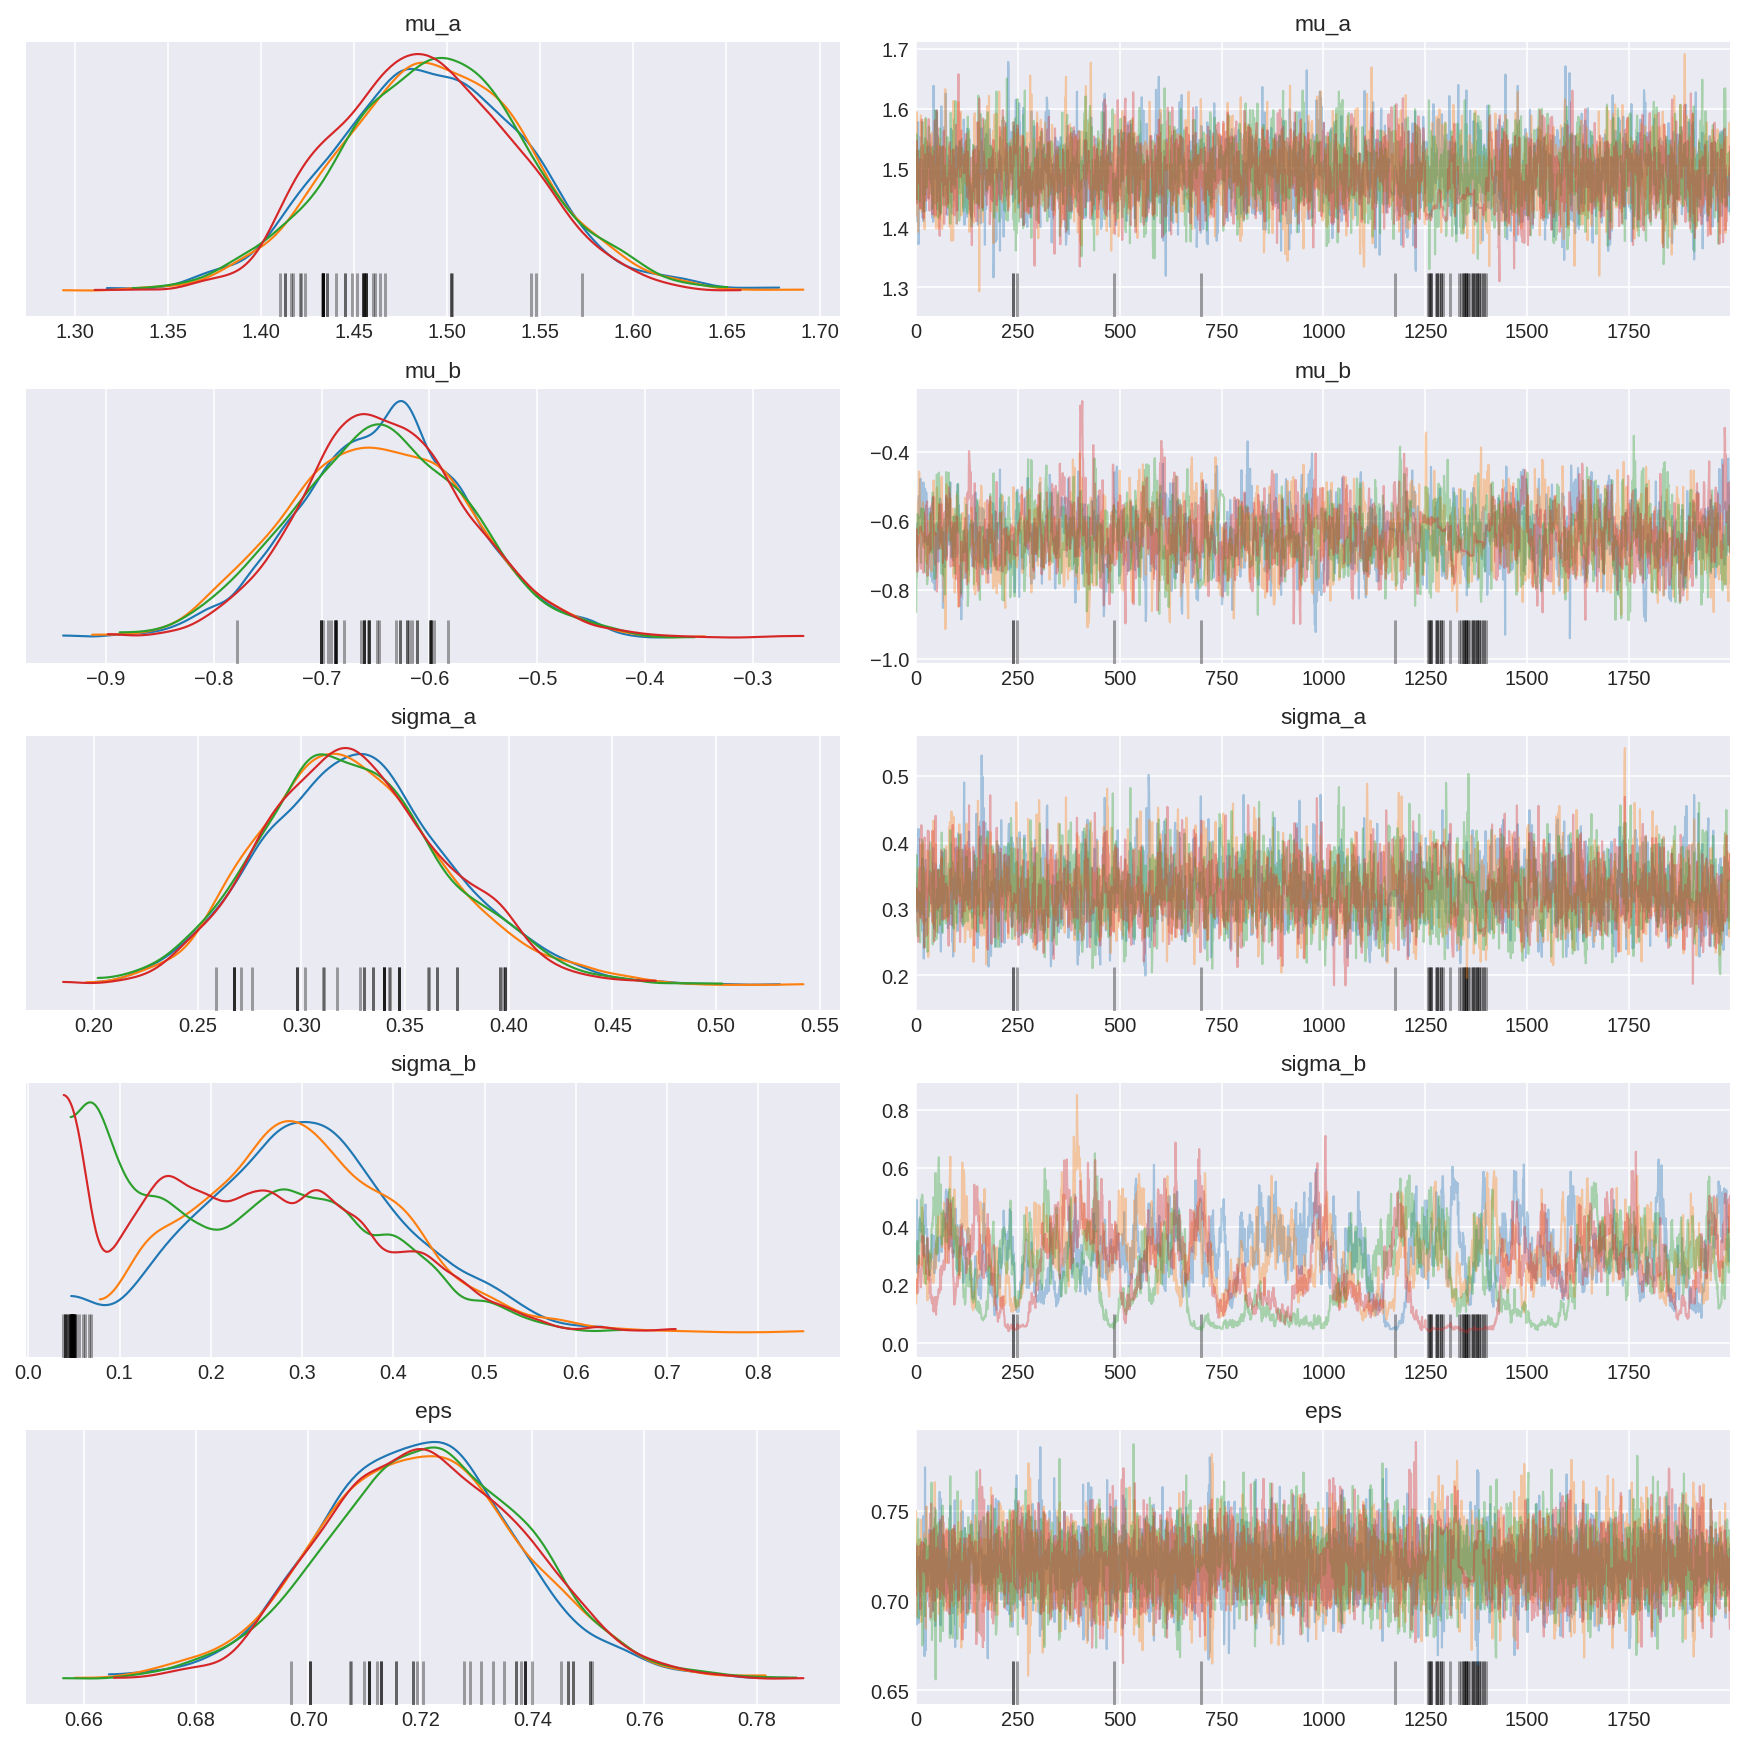

In [16]:
_ = az.plot_trace(inference_data, var_names=global_vars, divergences=True, figsize=(12, 12))

We see that there is poor agreement in the posterior marginal estimates for `sigma_b` across the different chains, particularly for small values, and that all of the divergent transitions occured in iterations beginning at states corresponding to small `sigma_b` values, suggesting it is the region of the posterior where `sigma_b` is small which is causing the issues. There are various changes to the parameterisation of the distribution or adaptation parameters we could use to try to eliminate these divergent transitions - see for example these [Stan](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html) and [PyMC3](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html) case-studies / tutorials.

## Convenience function

To make it simpler to try out using Mici to sample from other PyMC3 models a convenience function is provided as a (partial) drop-in replacement for the PyMC3 `sample` function, with the dynamic multinomial HMC implementation in Mici to generate the sampled traces.

In [17]:
def sample_with_mici(
        model=None, 
        draws=1000,
        init='auto',
        trace=None,
        chains=None,
        cores=None,
        tune=1000,
        progressbar=True,
        random_seed=None,
        jitter_max_retries=10,
        return_inferencedata=False,
        target_accept=0.8,
        max_treedepth=10,
    ):
    """Generate approximate samples from posterior distribution defined by a PyMC3 model.
    
    Uses dynamic multinomial HMC algorithm in Mici with adaptive warm-up phase.
    
    Parameters
    ----------
    model : Model
        PyMC3 model defining posterior distribution to sample from.
    draws : int
        The number of samples to draw. 
    init : str
        Initialization method to use. One of:
        * adapt_diag: Start with a identity mass matrix and then adapt a diagonal based on the
          variance of the tuning samples. All chains use the test value (usually the prior mean)
          as starting point.
        * jitter+adapt_diag: Same as ``adapt_diag``, but add uniform jitter in [-1, 1] to the
          starting point in each chain. Also chosen if `init=="auto"`.
        * adapt_full: Adapt a dense mass matrix using the sample covariances
    trace : list, or MultiTrace
        A list of variables to track. If `None`, `model.unobserved_RVs` is used.
    chains : int
        The number of chains to sample. Running independent chains is important for some
        convergence statistics and can also reveal multiple modes in the posterior. If `None`,
        then set to either `cores` or 2, whichever is larger.
    cores : int
        The number of chains to run in parallel. If `None`, set to the number of CPUs in the
        system, but at most 4.
    tune : int
        Number of iterations to tune, defaults to 1000. Samplers adjust the step sizes, scalings or
        similar during tuning. Tuning samples will be drawn in addition to the number specified in
        the ``draws`` argument, and will be discarded.
    progressbar : bool, optional default=True
        Whether or not to display a progress bar.
    random_seed : int
        Seed for Numpy random number generator.
    jitter_max_retries : int
        Maximum number of repeated attempts (per chain) at creating an initial matrix with uniform jitter
        that yields a finite probability. This applies to `jitter+adapt_diag` and `jitter+adapt_full`
        init methods.
    return_inferencedata : bool
        Whether to return the traces as an `arviz.InferenceData` (True) object or a dict (False).
        
    Returns
    -------
    traces : dict or arviz.InferenceData
        A dictionary or ArviZ ``InferenceData`` object that contains the samples.
    """
    
    model = pm.modelcontext(model)
    
    if cores is None:
        cores = min(4, os.cpu_count() // 2)  # assume 2 threads per CPU core
    
    if chains is None:
        chains = max(2, cores)    
        
    if trace is None:
        trace = model.unobserved_RVs
        
    if init == 'auto' or 'jitter+adapt_diag':
        use_dense_metric = False
        jitter_init = True
    elif init == 'adapt_diag':
        use_dense_metric = False
        jitter_init = False
    elif init == 'adapt_full':
        use_dense_metric = True
        jitter_init = False
    else:
        raise ValueError(
            'init must be one of "auto", "jitter+adapt_diag", "adapt_diag" or "adapt_full"'
        )
    
    val_and_grad_log_dens = model.logp_dlogp_function()
    val_and_grad_log_dens.set_extra_values({})
    
    def grad_neg_log_dens(pos):
        val, grad = val_and_grad_log_dens(pos)
        return -grad, -val
    
    def neg_log_dens(pos):
        val, _ = val_and_grad_log_dens(pos)
        return -val
    
    def trace_func(state):
        var_dict = val_and_grad_log_dens.array_to_dict(state.pos)
        trace_dict = {}
        for rv in trace:
            if rv.name in var_dict:
                trace_dict[rv.name] = var_dict[rv.name]
            else:
                trace_dict[rv.name] = rv.transformation.backward_val(var_dict[rv.transformed.name])
        trace_dict['energy'] = system.h(state)
        return trace_dict
                
    system = mici.systems.EuclideanMetricSystem(
        neg_log_dens=neg_log_dens, grad_neg_log_dens=grad_neg_log_dens
    )
    
    integrator = mici.integrators.LeapfrogIntegrator(system)
    rng = np.random.default_rng(random_seed)
    sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
    
    step_size_adapter = mici.adapters.DualAveragingStepSizeAdapter(target_accept)
    metric_adapter = (
        mici.adapters.OnlineCovarianceMetricAdapter() if use_dense_metric 
        else mici.adapters.OnlineVarianceMetricAdapter()
    )
    adapters = [step_size_adapter, metric_adapter]
    
    if jitter_init:
        mean = val_and_grad_log_dens.dict_to_array(model.test_point)
        init_states = []
        for c in range(chains):
            for t in range(jitter_max_retries):
                pos = mean + rng.uniform(-1, 1, mean.shape)
                if np.isfinite(val_and_grad_log_dens(pos)[0]):
                    break
            init_states.append(pos)
    else:
        init_states = [val_and_grad_log_dens.dict_to_array(model.test_point) for c in range(chains)]
    
    final_states, traces, stats =  sampler.sample_chains_with_adaptive_warm_up(
        n_warm_up_iter=tune, 
        n_main_iter=draws, 
        init_states=init_states, 
        adapters=adapters, 
        trace_funcs=[trace_func], 
        n_process=cores,
        display_progress=progressbar,
        monitor_stats=['accept_stat', 'n_step', 'diverging']
    )
    
    if return_inferencedata:
        return az.InferenceData(
            posterior=arviz.dict_to_dataset(traces),
            sample_stats=arviz.dict_to_dataset(stats)
        )
    else:
        return {k: np.stack(v) for k, v in traces.items()}
    

Using this function we can simply replace a `pm.sample` call within a PyMC3 model context with a corresponding `sample_with_mici` as illustrated below. Note that by default `sample_with_mici` returns a *dictionary* of NumPy arrays rather than the `MultiTrace` object returned by PyMC3. Both allow access of the chain samples for each traced variable using a string index, however the `MultiTrace` object also provides other indexing variants. If the `return_inferencedata` argument is set to `True` an ArviZ `InferenceData` object will instead be returned, providing more exact match for the PyMC3 call in this case.

In [18]:
with model:
    pymc3_traces = pm.sample(draws=2000, tune=2000, target_accept=0.9, random_seed=seed)
    display(az.summary(pymc3_traces, var_names=global_vars))
    mici_traces = sample_with_mici(draws=2000, tune=2000, target_accept=0.9, random_seed=seed)
    display(az.summary(mici_traces, var_names=global_vars))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains, 329 divergences: 100%|██████████| 16000/16000 [00:41<00:00, 381.40draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7463650199587564, but should be close to 0.9. Try to increase the number of tuning steps.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.632464130455619, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parame

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,1.491,0.050,1.400,1.587,0.001,0.001,3057.0,3047.0,3060.0,5212.0,1.00
mu_b,-0.647,0.082,-0.798,-0.490,0.003,0.002,999.0,992.0,999.0,2395.0,1.01
sigma_a,0.325,0.047,0.247,0.418,0.002,0.001,914.0,914.0,918.0,1324.0,1.00
sigma_b,0.265,0.118,0.053,0.460,0.018,0.013,42.0,42.0,35.0,107.0,1.12
eps,0.720,0.018,0.685,0.753,0.000,0.000,2257.0,2257.0,2271.0,2872.0,1.00


Sampling stage: Initial fast adaptive [00:10] > Slow adaptive (1/6) [00:07] > Slow adaptive (2/6) [00:08] > Slow adaptive (3/6) [00:08] > Slow adaptive (4/6) [00:10] > Slow adaptive (5/6) [00:16] > Slow adaptive (6/6) [00:32] > Final fast adaptive [00:08] > Main non-adaptive [00:44]

Chain 1/4: 100%|██████████|2000/2000 [00:36<00:00, 54.17it/s, accept_stat=0.949, n_step=37.3, diverging=0.00]

Chain 2/4: 100%|██████████|2000/2000 [00:37<00:00, 53.16it/s, accept_stat=0.905, n_step=37.7, diverging=0.00300]

Chain 3/4: 100%|██████████|2000/2000 [00:37<00:00, 53.83it/s, accept_stat=0.939, n_step=37.5, diverging=0.00200]

Chain 4/4: 100%|██████████|2000/2000 [00:37<00:00, 53.16it/s, accept_stat=0.954, n_step=37.8, diverging=0.00]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,1.492,0.052,1.396,1.590,0.001,0.001,2810.0,2807.0,2842.0,4651.0,1.00
mu_b,-0.649,0.084,-0.804,-0.488,0.003,0.002,754.0,721.0,775.0,1234.0,1.00
sigma_a,0.326,0.046,0.237,0.409,0.001,0.001,2135.0,2135.0,2082.0,3344.0,1.00
sigma_b,0.282,0.114,0.076,0.494,0.009,0.006,179.0,179.0,162.0,89.0,1.01
eps,0.720,0.018,0.687,0.756,0.000,0.000,4021.0,3970.0,4170.0,3231.0,1.00
